# 특징
- Classifier만 학습
 
# TODO
- Loss는 CPU에서 계산하는게 빠를수도 있겠다

# Library


In [1]:
# ! pip install wandb opencv-python-headless==4.2.0.32 albumentations==1.1.0 torch-summary timm==0.5.4 einops joblib icecream xmltodict

# Import

In [2]:
import os
from pathlib import Path
from pprint import pprint
from collections import defaultdict

# XML Parsing
import xmltodict
import json

# Pytorch
import torch
import torch.nn as nn
import torchvision.datasets as transforms
from torchvision.datasets import VOCDetection
from torch.utils.data import Dataset, DataLoader
import timm
from einops import rearrange, reduce, repeat
from torchsummary import summary



# Image Processing
import cv2
import numpy as np
from PIL import Image, ImageDraw
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


# Debugging
from icecream import ic

# math, plotting
import matplotlib.pyplot as plt
from math import sqrt
import random

from tqdm import tqdm



/opt/homebrew/Caskroom/miniforge/base/envs/pytorch-nightly/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CONFIG

In [3]:
CONFIG = dict(
    S=7,
    B=2,
    C=20,
    seed=42,
    batch_size=4,
    epoch = 150,
    height=384,   # y
    width=384,    # x
    lambda_coord=5.,
    lambda_noobj=0.5,
    lr=1e-5,
    start_epoch=1,
    # device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    device=torch.device("mps" if torch.has_mps else "cpu"),
)
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"
ic.disable()


# WANDB

In [4]:
import wandb
# If you don't want your script to sync to the cloud
os.environ['WANDB_MODE'] = 'offline'

run = wandb.init(project="YOLOv1", entity="jiwon7258", config = CONFIG, job_type='train')
run.name = 'MPS'


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


# SET SEED

In [5]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)


set_seed(CONFIG['seed'])



# Dataset and Dataloader


참고 블로그

-   [PASCAL VOC DATASET 설명](https://ctkim.tistory.com/190)


In [6]:
# 픽셀값으로 되어 있는 bbox 값을 (이미지 크기에 대한) 상대값으로 변경해줍니다
def bbox_transform(bbox: dict, img_height, img_width) -> dict:
    bbox = bbox.copy()
    # 기존 값을 변경
    bbox['xmin'] = int(bbox['xmin']) / img_width        # must be float
    bbox['xmax'] = int(bbox['xmax']) / img_width
    bbox['ymin'] = int(bbox['ymin']) / img_height
    bbox['ymax'] = int(bbox['ymax']) / img_height
    bbox['x'] = (bbox['xmin'] + bbox['xmax']) / 2
    bbox['y'] = (bbox['ymin'] + bbox['ymax']) / 2
    bbox['w'] = bbox['xmax'] - bbox['xmin']
    bbox['h'] = bbox['ymax'] - bbox['ymin']
    # 새 값 추가
    bbox['sqrt_w'] = sqrt(bbox['w'])
    bbox['sqrt_h'] = sqrt(bbox['h'])

    return bbox


In [7]:
def print_img(img, annotation):
    """  
    {'annotation': {'filename': '000017.jpg',
                'folder': 'VOC2007',
                'object': [{'bndbox': {'xmax': '279',
                                       'xmin': '185',
                                       'ymax': '199',
                                       'ymin': '62'},
                            'difficult': '0',
                            'name': 'person',
                            'pose': 'Left',
                            'truncated': '0'},
                           {'bndbox': {'xmax': '403',
                                       'xmin': '90',
                                       'ymax': '336',
                                       'ymin': '78'},
                            'difficult': '0',
                            'name': 'horse',
                            'pose': 'Left',
                            'truncated': '0'}],
                'owner': {'flickrid': 'genewolf', 'name': 'whiskey kitten'},
                'segmented': '0',
                'size': {'depth': '3', 'height': '364', 'width': '480'},
                'source': {'annotation': 'PASCAL VOC2007',
                           'database': 'The VOC2007 Database',
                           'flickrid': '228217974',
                           'image': 'flickr'}}}
    """

    # 1. RGB로 바꾸어주기
    img = img.convert('RGB')

    # 2. 사각형 그리기
    # (xmin, ymin, xmax, ymax)
    draw = ImageDraw.Draw(img)
    for object in annotation['annotation']['object']:
        box = (float(object['bndbox']['xmin']), float(object['bndbox']['ymin']), float(object['bndbox']['xmax']),  float(object['bndbox']['ymax']))
        color = tuple(np.random.randint(low= 0, high= 256, size=3))
        width = 3
        text_pos = ((box[0]) + width, box[1])

        draw.rectangle(box, outline=color, width=width)
        draw.text(text_pos, object['name'], color = color)

    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img)
    

In [8]:
def custom_collate_fn(datas : list):
    """ 
    1. 이미지들의 크기를 조정하고, 배치 단위 텐서로 변환합니다.
    2. list of label dictionary를 반환합니다.
    Args :
        datas : is a list of tuple (image, dictionary)

    Return :
        batch_img (torch.Tensor) : (B, C, H, W)
        label_list (list) : a list of dictionary
    """
    img_list = list()
    label_list = list()

    for i in range(len(datas)):
        img = np.array(datas[i][0])   # PIL Image -> numpy array, (H, W, C)
        original_img_height = img.shape[0]
        original_img_width = img.shape[1]
        label = datas[i][1]     # dict

        # label['original_img_height'] = original_img_height
        # label['original_img_width'] = original_img_width

        # numpy -> tensor
        transform = A.Compose([
            A.Resize(CONFIG['height'], CONFIG['width']),
            ToTensorV2(),
        ])
        img_tensor = transform(image=img)['image'].to(dtype=torch.float)    # (C, H, W) Tensor

        # 각 이미지에 포함되어 있는 object 정보들에 대한 list
        original_obj_list = label['annotation']['object']

        """  
        데이터를 가공합니다.
        bbox 값을 (이미지 크기에 대한) 상대값으로 설정

        obj_list (list) : a list of dictionary
            e.g. obj_list[1]['name'] : 1번째 object의 name
        """
        obj_list = list()
        for obj in original_obj_list:
            ratio_bbox = bbox_transform(
                bbox=obj['bndbox'], img_height=original_img_height, img_width=original_img_width)

            obj_info = dict()
            obj_info['name'] = obj['name']
            obj_info['bbox'] = ratio_bbox

            obj_list.append(obj_info)
        
        label['annotation']['object'] = obj_list

        img_list.append(img_tensor)
        label_list.append(label)


    batch_img = torch.stack(img_list, dim=0)

    return batch_img, label_list



In [9]:
from xml.etree.ElementTree import Element as ET_Element
try:
    from defusedxml.ElementTree import parse as ET_parse
except ImportError:
    from xml.etree.ElementTree import parse as ET_parse
import collections


from typing import Any, Callable, Dict, Optional, Tuple, List

def parse_voc_xml(node: ET_Element) -> Dict[str, Any]:
    # 리턴값은 일반 Dict
    voc_dict: Dict[str, Any] = {}

    # children : [자식element1, 자식element2, 자식element3, ...]
    children = list(node)
    if children:
        # 중복된 태그들은 하나의 list로 관리한다
        # e.g.) {object : [{ }, { }, { }, ... ] }
        def_dic: Dict[str, Any] = collections.defaultdict(list)
        for dc in map(VOCDetection.parse_voc_xml, children):
            for ind, v in dc.items():
                def_dic[ind].append(v)
        if node.tag == "annotation":
            def_dic["object"] = [def_dic["object"]]
        voc_dict = {node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}
    # element에 text가 있는 경우
    if node.text:
        # text를 얻는다
        text = node.text.strip()
        # 자식이 없는경우
        if not children:
            # {tag : text}를 voc_dict에 추가한다
            voc_dict[node.tag] = text
    return voc_dict

class trainDataset(Dataset):
    """  
    Train 커스텀 데이터셋
    """
    def __init__(self, root:str ='./'):
        self.root = root
        self.img_list_path = Path(root) / Path('VOCdevkit/VOC2007/ImageSets/Main/train.txt')
        self.img_list = list()
        with open(self.img_list_path) as f:
            for line in f:
                self.img_list.append(line.strip())



    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index : int):
        """  
        Return :
        - img (PIL image)
        - annotation (dict)
        """

        self.img_file_name = self.img_list[index]
        self.img_path = Path(self.root) / Path('VOCdevkit/VOC2007/JPEGImages') / Path(self.img_file_name + '.jpg')
        annotation_path = Path(self.root) / Path('VOCdevkit/VOC2007/Annotations') / Path(self.img_file_name + '.xml')

        annotation_str =''
        with open(annotation_path) as f:
            for line in f:
                annotation_str += line

        # pprint(annotation_str)
        
        img = Image.open(self.img_path)
        target = parse_voc_xml(ET_parse(annotation_path).getroot())


        return (img, target)


class valDataset(Dataset):
    """  
    Train 커스텀 데이터셋
    """
    def __init__(self, root:str ='./'):
        self.root = root
        self.img_list_path = Path(root) / Path('VOCdevkit/VOC2007/ImageSets/Main/val.txt')
        self.img_list = list()
        with open(self.img_list_path) as f:
            for line in f:
                self.img_list.append(line.strip())



    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index : int):
        """  
        Return :
        - img (PIL image)
        - annotation (dict)
        """

        self.img_file_name = self.img_list[index]
        self.img_path = Path(self.root) / Path('VOCdevkit/VOC2007/JPEGImages') / Path(self.img_file_name + '.jpg')
        annotation_path = Path(self.root) / Path('VOCdevkit/VOC2007/Annotations') / Path(self.img_file_name + '.xml')

        annotation_str =''
        with open(annotation_path) as f:
            for line in f:
                annotation_str += line

        # pprint(annotation_str)
        
        img = Image.open(self.img_path)
        # TODO : Parse 분석하기
        target = parse_voc_xml(ET_parse(annotation_path).getroot())

        return (img, target)

In [10]:
root_path = '../datasets'
train_dataset_download = VOCDetection(root=root_path, year='2007',
                       image_set='train', download=True,)
train_dataset = trainDataset(root=root_path)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=CONFIG['batch_size'], collate_fn=custom_collate_fn)
val_dataset = valDataset(root=root_path)
val_dataloader = DataLoader(dataset = val_dataset, batch_size=CONFIG['batch_size'], collate_fn=custom_collate_fn)

# test_dataset_download = VOCDetection(root='./test/', year='2007', image_set='test', download=True)
# test_dataloader = DataLoader(dataset = test_dataset_download, batch_size=CONFIG['batch_size'], collate_fn=custom_collate_fn)git

Using downloaded and verified file: ./VOCtrainval_06-Nov-2007.tar
Extracting ./VOCtrainval_06-Nov-2007.tar to ./


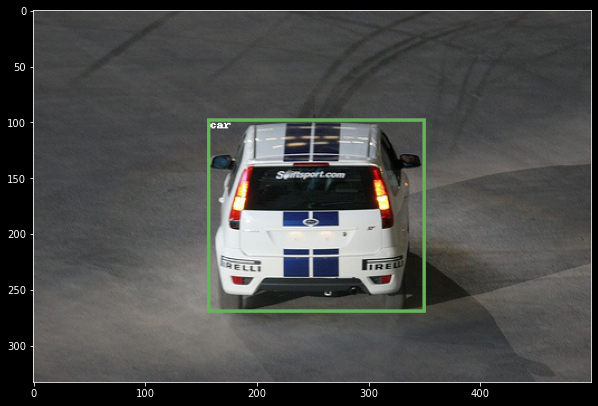

In [11]:
ic.enable()
test_sample = trainDataset()
img, annotation = test_sample[0]
# print(annotation)
print_img(img,annotation)

다음 과정을 통해 라벨에 번호를 부여합니다.

번호-라벨 쌍이 `labels_dict`에 저장됩니다


In [12]:
labels_list = ['person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'aeroplane',
               'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train', 'bottle',
               'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor']

labels_name_dict = dict()
name_labels_dict = dict()
for i, label in enumerate(labels_list):
    labels_name_dict[i] = label
    name_labels_dict[label] = i


# Model


In [13]:
""" 
input : (3, 448, 448) - (C, H, W)
output : S * S * (B * 5 + C)
"""

# TODO : 적당한 backbone 모델로 변경하기
class Yolo(nn.Module):
    def __init__(self, S, B, C):
        super().__init__()
        # 모델 상수
        self.S = S
        self.B = B
        self.C = C
        
        # backbone
        self.backbone = timm.create_model('vit_base_patch32_384', pretrained=True)
        self.backbone.reset_classifier(self.S * self.S * (5 * self.B + self.C))
        self.sigmoid = nn.Sigmoid()

        # freeze backbone
        freeze_exception = ['norm.weight',
                            'norm.bias',
                            'head.weight',
                            'head.bias']

        for name, param in self.backbone.named_parameters():
            if (name not in freeze_exception):
                # print(name)
                param.requires_grad = False




    def forward(self, x):
        out = self.backbone(x)
        out = self.sigmoid(out).clone()
        out = rearrange(out, 'bs (S s X) -> bs S s X', S = self.S, s = self.S)

        return out


In [14]:
yolo = Yolo(S=CONFIG['S'], B=CONFIG['B'], C=CONFIG['C'])
# pred : (S, S, (B *5 + C))
# pred = yolo(img)
# ic.enable()
# yolo(torch.randn(1,3,384,384)).shape
# summary(yolo, (3,384,384))
yolo = yolo.to(CONFIG['device'])


In [15]:
# for name, param in yolo.named_parameters():
#     pprint(name + " : " + str(param.requires_grad))

In [16]:
# wandb.restore('YOLOV1epoch52_Loss6.2437.bin', 'jiwon7258/YOLOv1/3kufj7nx', root='./')
# yolo.load_state_dict(torch.load('YOLOV1epoch52_Loss6.2437.bin',
#                       map_location=CONFIG['device']))

# Optimizer

In [17]:
optimizer = torch.optim.Adam(params=yolo.parameters(), lr=CONFIG['lr'])

# Functions

In [18]:
# (x,y,w,h) tensor 둘을 받아서 IoU를 계산합니다
def IOU(bbox1: torch.Tensor, bbox2: torch.Tensor) -> torch.Tensor:
    
    assert len(bbox1) == 4, 'bbox1이 이상합니다'
    assert len(bbox2) == 4, 'bbox2가 이상합니다'

    
    max_x1 = bbox1[0] + (bbox1[2] / 2)
    min_x1 = bbox1[0] - (bbox1[2] / 2)
    max_y1 = bbox1[1] + (bbox1[3] / 2)
    min_y1 = bbox1[1] - (bbox1[3] / 2)

    max_x2 = bbox2[0] + (bbox2[2] / 2)
    min_x2 = bbox2[0] - (bbox2[2] / 2)
    max_y2 = bbox2[1] + (bbox2[3] / 2)
    min_y2 = bbox2[1] - (bbox2[3] / 2)

    # 직사각형 A, B의 넓이를 구한다.
    # get area of rectangle A and B
    rect1_area = (max_x1 - min_x1) * (max_y1 - min_y1)
    rect2_area = (max_x2 - min_x2) * (max_y2 - min_y2)

    # Intersection의 가로와 세로 길이를 구한다.
    # get length and width of intersection.
    intersection_x_length = min(max_x1, max_x2) - max(min_x1, min_x2)
    intersection_y_length = min(max_y1, max_y2) - max(min_y1, min_y2)
    
    
    # width와 length의 길이가 유효하다면 IoU를 구한다.
    # If the width and length are valid, get IoU.
    if (bool(intersection_x_length > 0) & bool(intersection_y_length > 0)):
        intersection_area = intersection_x_length * intersection_y_length
        union_area = rect1_area + rect2_area - intersection_area
        ret = intersection_area / union_area
    else :
        ret = 0
    return torch.Tensor([ret])

""" 
코드 출처
https://gaussian37.github.io/math-algorithm-iou/
"""




' \n코드 출처\nhttps://gaussian37.github.io/math-algorithm-iou/\n'

In [19]:
def sum_squared_loss(pred : torch.Tensor, target : torch.Tensor):
    if pred.dim() == 0:
        pred.unsqueeze_(0)
    if target.dim() == 0:
        target.unsqueeze_(0)

    assert len(pred) == len(target), '에러 : 두 텐서의 길이가 다릅니다'

    length = len(pred)
    
    sum = torch.Tensor([0])
    for i in range(length):
        sum = sum + pow((pred[i] - target[i]), 2)

    return sum


In [24]:
def loss_func(pred : torch.Tensor, label_list : list):
    """  
    Loss를 계산합니다.

    Args:
        label_list (list): a list of dictionary
        pred (torch.Tensor): (batch, S, S, 5*B + C) = (batch, 7, 7, 30)
    """
    
    # ============ Loss 계산 ===========

    mse = torch.nn.MSELoss(reduction='sum')
    loss_list = list()

    # 각 batch 중, 하나의 데이터마다 각각 loss를 계산한다
    for batch, label in enumerate(label_list):
        """  
        Args
            label (dict) 
                e.g. {'annotation': {'filename': '000012.jpg',
                        'folder': 'VOC2007',
                        'object': [{'bbox': {'h': 0.5195195195195196,
                                            'sqrt_h': 0.7207770248277338,
                                            'sqrt_w': 0.6244997998398398,
                                            'w': 0.38999999999999996,
                                            'x': 0.507,
                                            'xmax': 0.702,
                                            'xmin': 0.312,
                                            'y': 0.5510510510510511,
                                            'ymax': 0.8108108108108109,
                                            'ymin': 0.2912912912912913},
                                    'name': 'car'}],
                        'owner': {'flickrid': 'KevBow', 'name': '?'},
                        'segmented': '0',
                        'size': {'depth': '3', 'height': '333', 'width': '500'},
                        'source': {'annotation': 'PASCAL VOC2007',
                                'database': 'The VOC2007 Database',
                                'flickrid': '207539885',
                                'image': 'flickr'}}}
        """

        # 이미지 height, width 저장
        img_height = CONFIG['height']
        img_width = CONFIG['width']

        # 각 이미지에 포함되어 있는 object 정보들에 대한 list
        obj_list = label['annotation']['object']
        num_obj = len(obj_list)

        # 순회를 체크하기 위해 S X S Grid를 만든다.
        # 기본값은 0
        # object가 있는 cell은 1로 표시한다
        GRID = np.zeros((CONFIG['S'], CONFIG['S']))

        # ============= Object가 존재하는 Cell의 Loss를 먼저 계산한다 =================
        for n in range(num_obj):

            """
            Example of obj_info:
            {'bbox': {'h': 0.93048128342246,
                    'sqrt_h': 0.9646145776539249,
                    'sqrt_w': 0.5709640969448079,
                    'w': 0.326,
                    'x': 0.20299999999999999,
                    'xmax': 0.366,
                    'xmin': 0.04,
                    'y': 0.4839572192513369,
                    'ymax': 0.9491978609625669,
                    'ymin': 0.01871657754010695},
            'name': 'person'}
            """
            obj_info = obj_list[n]

            # (i,j) cell에 떨어진다고 할 때, (i,j)를 찾는다
            x = obj_info['bbox']['x']
            y = obj_info['bbox']['y']
            i = int(y * CONFIG['S'])
            j = int(x * CONFIG['S'])

            # 이미 해당 cell에 object가 있었다면 pass
            # YOLO는 한 cell에서 단 하나의 object만을 탐지하기 때문이다
            if (GRID[i][j] == 1):
                continue
            else:
                GRID[i][j] = 1

            # classification loss
            pred_probs = pred[batch, i, j, 5*CONFIG['B']:]           # (C,) tensor
            true_label = name_labels_dict[obj_info['name']]      # Answer Label e.g.) 4
            label_probs = torch.zeros_like(pred_probs)
            label_probs[true_label] = 1.0
            # print('pred_probs : ', pred_probs)
            # print('label_probs :', label_probs)
            loss_list.append(mse(pred_probs, label_probs))

            # print('loss_list : ', loss_list)

            # Responsible한 bbox를 찾는다 : target bbox와의 IOU가 제일 큰 bbox
            max_IOU = torch.Tensor([-1]).to('cpu')
            reponsible_bbox_num = -1

            # num_bbox 0 ~ B-1
            # TODO 
            for num_bbox in range(CONFIG['B']):
                pred_coord = pred[batch, i, j, 5 * (num_bbox): 5*(num_bbox) + 4]
                target_coord = torch.Tensor(
                    [obj_info['bbox']['x'], obj_info['bbox']['y'], obj_info['bbox']['w'], obj_info['bbox']['h']]).to('cpu')
                iou = IOU(target_coord, pred_coord).to('cpu')
                if bool(iou > max_IOU):
                    reponsible_bbox_num = num_bbox
                    max_IOU = iou

            # print('max_IOU : ', max_IOU)

            for num_bbox in range(CONFIG['B']):
                pred_coord = pred[batch, i, j, 5 * (num_bbox): 5*(num_bbox) + 4]        # (4,) tensor
                pred_confidence = pred[batch, i, j, 5*(num_bbox) + 4].unsqueeze(0)                   # (1,) tensor
                # print('pred_confidence : ', pred_confidence.item())

                # responsible한 bbox의 경우
                # TODO inplace 연산 없이 sqrt로 바꾸기
                if (num_bbox == reponsible_bbox_num):
                    sqrt_pred_coord = torch.zeros_like(pred_coord)
                    sqrt_pred_coord[0] = pred_coord[0]
                    sqrt_pred_coord[1] = pred_coord[1]
                    sqrt_pred_coord[2] = sqrt(pred_coord[2])     # w -> sqrt(w)
                    sqrt_pred_coord[3] = sqrt(pred_coord[3])     # h -> sqrt(h)

                    target_coord = torch.Tensor(
                        [obj_info['bbox']['x'], obj_info['bbox']['y'], obj_info['bbox']['sqrt_w'], obj_info['bbox']['sqrt_h']])
                    target_coord = target_coord.to('cpu')

                    # localization(coordinate) loss
                    assert pred_coord.size() == target_coord.size()
                    loss_list.append(CONFIG['lambda_coord'] * \
                        mse(sqrt_pred_coord, target_coord))
                    # confidence error loss
                    assert pred_confidence.size() == max_IOU.size()
                    loss_list.append(mse(pred_confidence, max_IOU))

                # reponsible하지 않은 bbox의 경우
                else:
                    # If no object exists in cell, the  confidence scores should be zero
                    loss_list.append(CONFIG['lambda_noobj'] * mse(pred_confidence, torch.Tensor([0]).to('cpu')))

        # =========== Object가 존재하지 않는 Cell의 Loss ===========

        for i in range(CONFIG['S']):
            for j in range(CONFIG['S']):
                # 이미 loss를 계산했던 Cell인지 확인
                if (GRID[i][j] == 1):
                    continue
                else:
                    GRID[i][j] = 1

                for num_bbox in range(CONFIG['B']):
                    pred_confidence = pred[batch, i, j, 5*(num_bbox) + 4].unsqueeze(0)
                    loss_list.append(CONFIG['lambda_noobj'] * \
                        mse(pred_confidence, torch.Tensor([0]).to('cpu')))

    # print('loss_list : ', loss_list)
    loss = torch.sum(torch.stack(loss_list))  / len(label_list)
    
    return loss
                    


# Training Function

In [25]:
# Training
def train_one_epoch(epoch, dataloader, scheduler, device = 'cpu', batch_size = 1) :
    yolo.train()

    bar = tqdm(enumerate(dataloader), total=len(dataloader))

    loss_sum = 0
    epoch_loss = 0

    for step, (img, label) in bar:
        """  
        Args :
            img (torch.Tensor): (B, C, H, W)
            label (list) : list of dictionary
        """
        
        img = img.to(CONFIG['device'])
        
        pred = yolo(img)        # (batch, 7, 7, 30)
        # pred = rearrange(pred, '1 a b c -> a b c')

        # print(pred.requires_grad)

        optimizer.zero_grad()

        pred = pred.to('cpu')
        loss = loss_func(pred=pred, label_list=label)

        loss.backward()
        
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        loss_sum += loss.item()

        epoch_loss = loss_sum / (step + 1)
            
        bar.set_postfix(Epoch = epoch, Train_Loss = epoch_loss, LR=optimizer.param_groups[0]["lr"])

    return epoch_loss
    

In [26]:
def val_one_epoch(epoch, dataloader, device, batch_size):
    yolo.eval()

    bar = tqdm(enumerate(dataloader), total=len(dataloader))

    loss_sum : int = 0
    epoch_loss : int = 0

    for step, (img, label) in bar:
        img = img.to(device)
        
        pred = yolo(img)

        pred = pred.to('cpu')

        loss = loss_func(pred = pred, label_list = label)

        loss_sum += loss.item()

        epoch_loss = loss_sum / (step + 1)

        bar.set_postfix(Epoch = epoch, Valid_Loss = epoch_loss)
    
    return epoch_loss


In [27]:
torch.autograd.set_detect_anomaly(False)


def run_training():
    Epoch = CONFIG['epoch']

    # To log gradient
    wandb.watch(yolo)

    best_loss = np.inf
    history = defaultdict(list)
    START_EPOCH = CONFIG['start_epoch']
    FINETUNE_EPOCH = 3

    # Fine Tuning for 3 epoch
    for epoch in range(START_EPOCH, FINETUNE_EPOCH):
        train_loss = train_one_epoch(epoch=epoch, dataloader = train_dataloader, scheduler = None, device=CONFIG['device'], batch_size=CONFIG['batch_size'])

        val_loss = val_one_epoch(epoch = epoch, dataloader = val_dataloader, device = CONFIG['device'], batch_size= CONFIG['batch_size'])

        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)

        wandb.log(
            {
            'Train Loss' : train_loss,
            'Valid Loss' : val_loss,
            }
        )

        if val_loss < best_loss :
            best_loss = val_loss
            file_prefix = 'YOLOV1'
            save_path = "{}epoch{:.0f}_Loss{:.4f}.bin".format(
                file_prefix, epoch, best_loss)
            torch.save(yolo.state_dict(), save_path)
            wandb.save(save_path)

    for name, param in yolo.named_parameters():
        param.requires_grad = True
    
    for epoch in range(FINETUNE_EPOCH, Epoch):
        train_loss = train_one_epoch(epoch=epoch, dataloader = train_dataloader, scheduler = None, device=CONFIG['device'], batch_size=CONFIG['batch_size'])

        val_loss = val_one_epoch(epoch = epoch, dataloader = val_dataloader, device = CONFIG['device'], batch_size= CONFIG['batch_size'])

        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)

        wandb.log(
            {
            'Train Loss' : train_loss,
            'Valid Loss' : val_loss,
            }
        )

        if val_loss < best_loss :
            best_loss = val_loss
            file_prefix = 'YOLOV1'
            save_path = "{}epoch{:.0f}_Loss{:.4f}.bin".format(
                file_prefix, epoch, best_loss)
            torch.save(yolo.state_dict(), save_path)
            wandb.save(save_path)

    
    print("Best Loss: {:.4f}".format(best_loss))


ic.disable()
print('### Using Device {0} ###'.format(str(CONFIG['device'])))
run_training()

### Using Device mps ###


 14%|█▎        | 86/626 [00:11<01:09,  7.75it/s, Epoch=1, LR=1e-5, Train_Loss=36.1]


KeyboardInterrupt: 